In [1]:
import os
from os import walk
import copy
import pickle

import numpy as np
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd


# check if files can be opened
print(os.listdir("./"))

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only.")



['.DS_Store', 'data_32', 'models', 'model_train_val.ipynb', 'data_256', 'README.md', '.gitignore', '351.ipynb', 'train.py', '.ipynb_checkpoints', '.git', 'stats', 'Media']
PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


# Setup Network

In [2]:
b_size = 16
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5162, 0.4644, 0.3975], 
                                                    [0.2728, 0.2641, 0.2575])])
dataset = datasets.ImageFolder("./data_256/art_pictures/train",
                            transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=b_size, 
                                        shuffle=True, num_workers=4)

In [ ]:

# implementation of VGG-BN for 3*256*256 inputs
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True))

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True))

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))

        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))

        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))

        self.conv9 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))

        self.conv10 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))

        self.conv12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))

        self.conv13 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))

        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)


        self.adaptive = nn.AdaptiveAvgPool2d(output_size=(7,7))

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=25088, out_features = 4096, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features = 4096, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))

        self.fc3 = nn.Linear(in_features=4096, out_features = 10, bias = True)

    def forward(self, x):
        x = self.conv1(x) 
        x = self.conv2(x) 
        x = self.pool1(x) 
        x = self.conv3(x) 
        x = self.conv4(x) 
        x = self.pool2(x) 
        x = self.conv5(x) 
        x = self.conv6(x)   
        x = self.conv7(x)  
        x = self.pool3(x) 
        x = self.conv8(x) 
        x = self.conv9(x) 
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.adaptive(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()
net.to(device)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Start training
In case of interruption during training, change the save point variable to start from there</br>
Default save point value should be 0

In [11]:
save_point = 16 #in case connection lost, load data again

In [ ]:
check_point = {'model_state_dict':
               torch.load('./model_saves/epoch_{}.pth'.format(save_point),
                          map_location=torch.device(device))}
net.load_state_dict(check_point['model_state_dict'])

In [ ]:
num_epoch = 50
total_step = len(dataloader)
stats = np.empty((0,4), float)


for epoch in tqdm(range(save_point, num_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_correct = 0
    print('------ Starting Epoch [{}/{}] ------'.format(epoch+1, num_epoch))
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)

        # back prop
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()*inputs.size(0)
        curr_correct = torch.sum(preds == labels)
        running_correct += curr_correct
        stats = np.vstack((stats, np.array([curr_correct.cpu(), running_loss, running_correct.cpu(), (i+1)*b_size])))
        print('Epoch [{}/{}], Step [{}/{}], Running Loss: {:.4f}, running Correct: [{}/{}]'
            .format(epoch+1, num_epoch, i+1, total_step, running_loss, running_correct, (i+1)*b_size))

    #save trained model every epoch
    PATH = './model_saves/epoch_{}.pth'.format(epoch+1)
    torch.save(net.state_dict(), PATH)

    DF = pd.DataFrame(stats)
    DF.to_csv('./stats_saves/stats_epoch_{}.csv'.format(epoch+1)) 

print('Finished Training')


# Evaluation

In [5]:
test_set = datasets.ImageFolder("./data_256/art_pictures/test",
                               transform=transform)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True,batch_size=32)

## Evaluate over a range of saved models

In [ ]:
eval_epoch_start = 0;
eval_epoch_end = 50;

correct = 0
total = 0
all_preds = np.empty((0,32), int)
all_labels = np.empty((0,32), int)


with torch.no_grad():
    for epochs in range(eval_epoch_start, eval_epoch_end + 1):
        check_point = {'model_state_dict':
                       torch.load('./model_saves/epoch_{}.pth'.format(epochs),
                                  map_location=torch.device(device))}
        net.load_state_dict(check_point['model_state_dict'])
        for i, data in tqdm(enumerate(testloader, 0)):

            test_images, test_labels = data
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(test_images)
            # the class with the highest energy is what we choose as prediction
            preds = torch.argmax(outputs, dim=1)
            total += test_labels.size(0)
            correct += torch.sum(preds == test_labels)

            all_preds = np.append(all_preds, preds.cpu().numpy())
            all_labels = np.append(all_labels, test_labels.cpu().numpy())

        print('Accuracy of the network on the epoch {} : {} %'.format(epochs, 100 * correct / total))

## Evaluate accuracy of an epoch from one saved model

In [8]:
correct = 0
total = 0
all_preds = np.empty((0,32), int)
all_labels = np.empty((0,32), int)

load_path = './models/{}.pth'.format('epoch_19_bs16')

check_point = {'model_state_dict':torch.load(load_path, map_location=torch.device(device))}
net.load_state_dict(check_point['model_state_dict'])

with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        test_images, test_labels = data
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        preds = torch.argmax(outputs, dim=1)
        total += test_labels.size(0)
        correct += torch.sum(preds == test_labels)

        all_preds = np.append(all_preds, preds.cpu().numpy())
        all_labels = np.append(all_labels, test_labels.cpu().numpy())




313it [1:12:21, 13.87s/it]


## Generate Confusion Matrix

/var/folders/_x/wr_809dd1fn6w0377xcj_jnh0000gn/T/ipykernel_82887/2945793409.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axis_label)
/var/folders/_x/wr_809dd1fn6w0377xcj_jnh0000gn/T/ipykernel_82887/2945793409.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(axis_label)


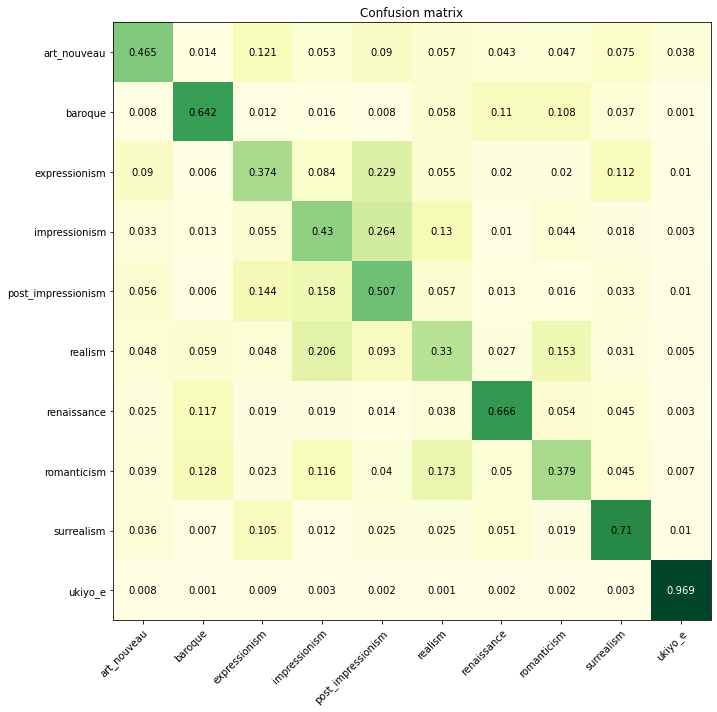

In [10]:
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt

axis_label =   ["art_nouveau",
                "baroque",
                "expressionism",
                "impressionism",
                "post_impressionism",
                "realism",
                "renaissance",
                "romanticism",
                "surrealism",
                "ukiyo_e"]

confmat = MulticlassConfusionMatrix(task="multiclass", num_classes=10)
confmat = confmat(torch.from_numpy(all_preds), torch.from_numpy(all_labels))
confmat.numpy()
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(confmat, cmap="YlGn")
ax.set_xticklabels(axis_label)
ax.set_yticklabels(axis_label)
ax.set_xticks(np.arange(len(axis_label)))
ax.set_yticks(np.arange(len(axis_label)))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(axis_label)):
    for j in range(len(axis_label)):
        if((i == j) and (i == 9)):
            text = ax.text(j, i, confmat[i, j].numpy()/1000,
                           ha="center", va="center", color="#FFFFFF")
        else:
            text = ax.text(j, i, confmat[i, j].numpy()/1000,
                           ha="center", va="center", color="#000000")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()